1. Tratamento dos dados
   - Balancear os dados de cada classe (criar dados de traffic)
2. Modelos
   - Ver outros classificadores que podem ser usados e testar
   - Usar usar optuna pra encontrar os melhores parâmetros para cada modelo
   - Validação cruzada e 30 iterações para ver média e mediana de cada métrica
3. **Atributos**
   - **Pesquisar mais atributos e justificar o uso de cada**
   - MFCCS e Zero crossing rate (ZCR)
4. Métricas
   - Pesquisar novas métricas: sensibilidade, especificidade, indice kappa, área sob ROC

In [55]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import librosa

# Pasta contendo os arquivos de áudio
audio_folder = "sounds"

# Listas para armazenar as características e os rótulos


audios = []

# Loop sobre as subpastas (traffic, ambulance, firetruck)
for label in ["traffic", "ambulance", "firetruck"]:
    label_folder = os.path.join(audio_folder, label)
    for file_name in os.listdir(label_folder):
        file_path = os.path.join(label_folder, file_name)
        if file_path.endswith(".wav"):
            # Carrega o arquivo de áudio
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            audios.append([audio_data, sample_rate, label])


In [65]:
features = []       
labels = []
folder_label = {"traffic": "traffic", "ambulance": "emergency", "firetruck": "emergency"}

for [audio_data, sample_rate, label] in audios:
    energy_mean = np.mean(audio_data**2)
    # mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    zero_crossings = librosa.zero_crossings(audio_data, pad=False)
    zero_crossing_rate = np.mean(zero_crossings) 
    
    _, _, spec = spectrogram(audio_data, fs=sample_rate)
    spec_mean = np.mean(spec)
    
    features.append([energy_mean, spec_mean, zero_crossing_rate])
    labels.append(folder_label[label])

In [66]:
from imblearn.over_sampling import SMOTE

# Converte as listas para arrays numpy
features = np.array(features)
labels = np.array(labels)

# Divide os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Cria e treina o classificador Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

count_emergency = np.count_nonzero( y_train_smote == "emergency")
count_traffic = np.count_nonzero(y_train_smote == "traffic")

clf.fit(X_train_smote, y_train_smote)

# Faz previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Calcula a acurácia do classificador

accuracy = accuracy_score(y_test, y_pred)

print("Acurácia:", accuracy)

Ocorrências de 'emergency': 289
Ocorrências de 'traffic': 289
Acurácia: 0.9888888888888889


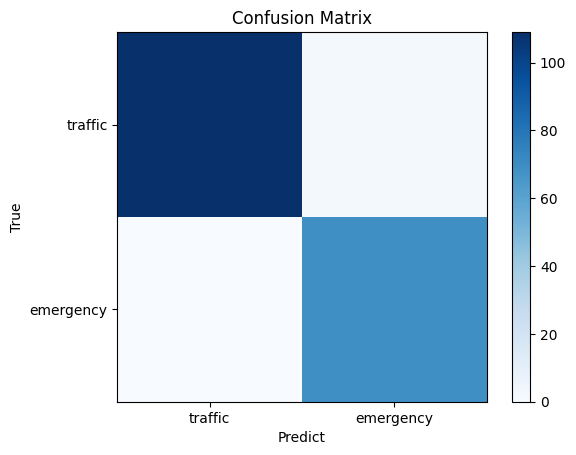

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confusion_matrix = confusion_matrix(y_test, y_pred)
classes = ["traffic", "emergency"]
# Exibe a matriz de confusão
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predict')
plt.ylabel('True')
plt.show()

In [59]:
print(confusion_matrix)

[[109   2]
 [  0  69]]


In [60]:
print(len(y_test))
for i in range(len(y_test)):
    if y_test[i] != y_pred[i] and (y_test[i] == "traffic" or y_pred[i] == "traffic"):
        print(y_test[i], y_pred[i])

180
emergency traffic
emergency traffic
